In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
os.chdir("/sfs/qumulo/qhome/jtb3sud/PARCv2")

import PARC.data.data_meta_learning as data
from PARC.model import model_meta_learning as model


2024-05-06 14:34:50.176740: I tensorflow/core/platform/cpu_feature_guard.cc:183] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-06 14:34:55.207896: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1636] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46594 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:23:00.0, compute capability: 8.6


# Data pipeline

In [2]:
# Get data and normalization
state_seq_whole, vel_seq_whole = data.clip_raw_data(sequence_length = 52, n_state_var = 3, purpose = "diff_training", folder_path = '/scratch/jtb3sud/meta_data/tnt/training', image_size = (128, 208))
state_seq_norm = data.data_normalization(state_seq_whole,3)
vel_seq_norm = data.data_normalization(vel_seq_whole,2)

Processing 183102.npy
(600, 1000, 280)
State seq case shapes: [(1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104)]
Processing 183142.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104), (1, 128, 208, 104)]
Processing 183105.npy
(600, 1000, 305)
State seq case shapes: [(1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156), (1, 128, 208, 156)]
Vel seq case shapes: [(1, 1

# Validation

In [3]:
state_seq_whole, vel_seq_whole = data.clip_raw_data(sequence_length = 52, n_state_var = 3, purpose = "test", folder_path = '/scratch/jtb3sud/meta_data/tnt/testing', image_size = (128, 208))
state_seq_norm_test = data.data_normalization_test(state_seq_whole, state_seq_norm[1], state_seq_norm[2],3)
vel_seq_norm_test = data.data_normalization_test(vel_seq_whole, vel_seq_norm[1], vel_seq_norm[2],2)

Processing 183116.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104)]
Processing 183130.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104)]
Processing 183104.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104)]
Processing 183109.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104)]
Processing 183129.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104)]
Processing 183137.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104)]
Processing 183138.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104)]
Processing 183121.npy
(600, 1000, 310)
State seq case shapes: [(1, 128, 208, 156)]
Vel seq case shapes: [(1, 128, 208, 104)]


In [4]:
#print(state_seq_whole)
#print(vel_seq_whole)
#print(state_seq_norm_test)
#print(vel_seq_norm_test)

In [5]:
### we need to save state_seq_whole and vel_seq_whole combined and saved as numpy array this is our ground truth. high priority
state_seq_whole.shape

(19, 128, 208, 156)

Image size: (128, 208)


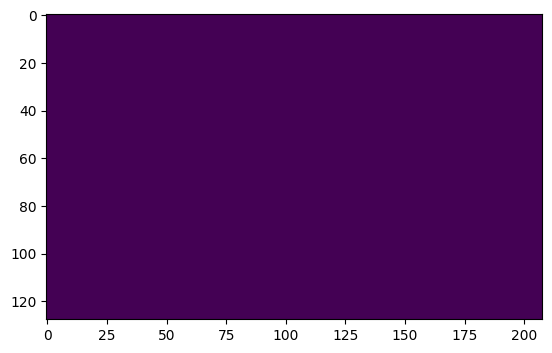

In [6]:
import matplotlib.pyplot as plt

# Assuming state_seq_norm_test is a numpy array containing image data
image = state_seq_norm_test[0, :, :, 0]

plt.imshow(image)

# Get the size of the image
image_size = image.shape
print("Image size:", image_size)
## 128 x 216 

## Load model

In [7]:
tf.keras.backend.clear_session()
parc_rk = model.PARCv2(n_state_var = 3, n_time_step = 52, step_size= 1/52, solver = "rk4", image_size = (128, 208))
parc_rk.compile()
parc_rk.differentiator.load_weights('/sfs/qumulo/qhome/jtb3sud/PARCv2/Pretrained_Weights/em/parc2_diff_rk4.h5')
parc_rk.integrator.load_weights('/sfs/qumulo/qhome/jtb3sud/PARCv2/Pretrained_Weights/em/parc2_int_rk4.h5')

In [8]:
print(state_seq_norm_test.shape)
print(vel_seq_norm_test.shape)

(19, 128, 208, 156)
(19, 128, 208, 104)


In [9]:
state_rk = []
outlier = []
# what is my input here? I am looping through all test samples.. am I looping through just one test sample?
# how do I compare ground truth 
for idx in range(18):
    if idx not in outlier:
        print(idx)
        #print(state_seq_norm_test)
        # what is the index helping with
        # why slice with these values?
        
        ## overall a data explanation is crucial for other users to have this 
        ## why must this equal 5 on the end? this should be explained
        state_var_current = state_seq_norm_test[idx:idx+1,:,:,24:27]
        velocity_current = vel_seq_norm_test[idx:idx +1,:,:,24:26]
        # Print shapes for debugging
        print("State shape:", state_var_current.shape)
        print("Velocity shape:", velocity_current.shape)
        ## detail what is being input here 
        pred_state = parc_rk.predict([state_var_current,velocity_current])
        pred_state_case = np.concatenate(pred_state, axis = -1)
        print(pred_state_case.shape)
        state_rk.append(pred_state_case)
state_rk = np.concatenate(state_rk, axis = 0)
print(state_rk.shape)       

0
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)


2024-05-06 14:43:11.157339: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8904
2024-05-06 14:43:12.105108: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:625] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - 358s 358s/step
(1, 128, 208, 260)
1
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
2
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
3
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
4
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
5
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
6
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128, 208, 260)
7
State shape: (1, 128, 208, 3)
Velocity shape: (1, 128, 208, 2)
1/1 [==============================] - 5s 5s/step
(1, 128,

In [10]:
import matplotlib.pyplot as plt
from PIL import Image

# Initialize list to store frames
frames = []

for i in range(52):
    # Plot the image
    plt.imshow(state_rk[6, :, :, i * 5], vmin=0, vmax=1, cmap='jet')
    plt.axis('off')  # Turn off axis

    # Convert the figure to a PIL image
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)  # Remove whitespace
    fig = plt.gcf()
    fig.canvas.draw()
    pil_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())

    # Close the plot to prevent display
    plt.close()

    # Append the PIL image to the frames list
    frames.append(pil_image)

# Save frames as a GIF
frames[0].save('state_rk_animation.gif', save_all=True, append_images=frames[1:], duration=100, loop=0)


/tmp/ipykernel_486928/2670686387.py:16: MatplotlibDeprecationWarning: The tostring_rgb function was deprecated in Matplotlib 3.8 and will be removed two minor releases later. Use buffer_rgba instead.
  pil_image = Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb())


In [11]:
import PARC.visualization.visualization_em as viz
## visualization needs to be explained

In [12]:
# Denormalizing prediction data
pred_out = data.data_denormalization(state_rk,state_seq_norm[1] + vel_seq_norm[1],state_seq_norm[2] + vel_seq_norm[2], no_of_channel = 5)

In [13]:
# Save results file for plotting
np.save('/scratch/jtb3sud/parcv2_tatb.npy',pred_out)

In [14]:
## how do I get gt??? This needs to be explained...
viz.plot_field_evolution(pred_out, )

TypeError: plot_field_evolution() missing 3 required positional arguments: 'y_true', 'case_id', and 'options'